In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import mean_squared_log_error
from Code.Torsh.TorchMacsumAggregationLearning import *
from Code.Torsh.Torsh_data_generation import *
from Code.Torsh.NetowrkMacsum import MacsumNetWithActivation
from catboost import CatBoostClassifier, Pool

%load_ext autoreload
%autoreload 2

Using device: cpu


In [2]:
def imputer_tout_avec_flags(df):
    """
    Gère toutes les colonnes avec des NaN :
    - Numériques : imputation par médiane + ajout d'un flag *_manquant
    - Catégorielles : imputation par 'inconnu' + ajout d'un flag *_manquant
    
    Paramètres :
        df (pd.DataFrame) : le DataFrame original
    
    Retour :
        pd.DataFrame : DataFrame modifié avec imputation et colonnes *_manquant
    """
    df = df.copy()
    
    for col in df.columns:
        if df[col].isna().sum() > 0:
            # Ajouter une colonne booléenne indiquant les NaN
            df[f"{col}_manquant"] = df[col].isna().astype(int)
            
            if df[col].dtype in ['float64', 'int64']:
                # Imputation par la médiane pour les numériques
                mediane = df[col].median()
                df[col] = df[col].fillna(mediane)
            else:
                # Imputation par 'inconnu' pour les objets/catégories
                df[col] = df[col].fillna('inconnu')
    return df
    

In [3]:
df = pd.read_csv("/Users/isaac/Downloads/prediction-interval-competition-ii-house-price/dataset.csv")
df = df.sample(frac=0.10, random_state=42)  
Y = df['sale_price'].to_numpy()
print(df)

            id   sale_date  sale_price  sale_nbr sale_warning  \
119737  119737  2009-08-15      254920       NaN                
72272    72272  2000-07-15      400000       1.0                
158154  158154  2016-11-15     1125000       5.0                
65426    65426  2006-01-15      360000       2.0                
30074    30074  2022-06-15      861000       3.0                
...        ...         ...         ...       ...          ...   
193188  193188  2010-10-15      645000       3.0                
35956    35956  2000-04-15      118450       1.0                
149399  149399  2012-03-15      600000       NaN                
97701    97701  2003-11-15      500000       2.0          40    
51732    51732  2013-06-15      701000       NaN                

            join_status  join_year  latitude  longitude  area  ...  \
119737            nochg       2025   47.4747  -122.3211    96  ...   
72272             nochg       2025   47.6682  -122.1841    93  ...   
158154  r

In [4]:
colonnes_cat = df.select_dtypes(include=['object', 'category']).columns.tolist()
colonnes_num = df.select_dtypes(include=['number']).columns.tolist()

print("Colonnes catégorielles :", colonnes_cat)
print("Colonnes numériques :", colonnes_num)

Colonnes catégorielles : ['sale_date', 'sale_warning', 'join_status', 'city', 'zoning', 'subdivision', 'submarket']
Colonnes numériques : ['id', 'sale_price', 'sale_nbr', 'join_year', 'latitude', 'longitude', 'area', 'present_use', 'land_val', 'imp_val', 'year_built', 'year_reno', 'sqft_lot', 'sqft', 'sqft_1', 'sqft_fbsmt', 'grade', 'fbsmt_grade', 'condition', 'stories', 'beds', 'bath_full', 'bath_3qtr', 'bath_half', 'garb_sqft', 'gara_sqft', 'wfnt', 'golf', 'greenbelt', 'noise_traffic', 'view_rainier', 'view_olympics', 'view_cascades', 'view_territorial', 'view_skyline', 'view_sound', 'view_lakewash', 'view_lakesamm', 'view_otherwater', 'view_other']


In [5]:
X=pd.get_dummies(df, columns=colonnes_cat, drop_first=True)
nan_counts = X.isna().sum()
nan_counts[nan_counts > 0].sort_values(ascending=False)

sale_nbr    4262
dtype: int64

In [6]:
X = imputer_tout_avec_flags(X)
nan_counts = X.isna().sum()
nan_counts[nan_counts > 0].sort_values(ascending=False)
X

,id,sale_price,sale_nbr,join_year,latitude,longitude,area,present_use,land_val,imp_val,...,submarket_K,submarket_L,submarket_M,submarket_N,submarket_O,submarket_P,submarket_Q,submarket_R,submarket_S,sale_nbr_manquant
119737,119737,254920,2.0,2025,47.4747,-122.3211,96,2,319000,270000,...,False,False,False,False,False,False,False,False,False,1
72272,72272,400000,1.0,2025,47.6682,-122.1841,93,2,785000,627000,...,False,False,False,False,False,False,True,False,False,0
158154,158154,1125000,5.0,2025,47.6276,-122.3210,13,29,519000,818000,...,False,False,False,False,False,False,False,False,False,0
65426,65426,360000,2.0,2025,47.4966,-121.7804,80,2,297000,362000,...,False,False,False,True,False,False,False,False,False,0
30074,30074,861000,3.0,2025,47.6050,-122.2975,15,2,571000,29000,...,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193188,193188,645000,3.0,2025,47.7217,-122.1567,93,2,840000,1072000,...,False,False,False,False,False,False,True,False,False,0
35956,35956,118450,1.0,2025,47.3762,-122.1485,62,29,210000,135000,...,False,True,False,False,False,False,False,False,False,0
149399,149399,600000,2.0,2025,47.6228,-122.3134,13,29,472000,526000,...,False,False,False,False,False,False,False,False,False,1
97701,97701,500000,2.0,2025,47.4733,-121.7299,80,2,479000,721000,...,False,False,False,True,False,False,False,False,False,0


In [7]:
#X = X.to_numpy(dtype=np.float64)
N = X.shape[1]
print(N)

7097


In [8]:
print(N)

7097


In [9]:
model_simple = MacsumNetWithActivation([N, N//2, 20,1],model_class= MacsumSigmoidTorch,alpha=0.1,gamma = 0.8,k_sigmoid=0.1)
model_simple.fit_autograd(X[:500],Y[:500],X[1001:1100],Y[1001:1100],learning_rate=1e-3,epsilon_conv=1e-6,n_epochs = 1000,beta1=0.8,beta2=0.99,batch_size=256)

Création d'un MacsumNet avec la fonction d'activation: relu


ValueError: could not determine the shape of object type 'DataFrame'

In [ ]:
i= [ 1,20,100]
print(Y[i])
model_simple.forward( torch.tensor(X[i], dtype=torch.float64)) 

[400000 585000 389500]


(tensor([0., 0., 0.], dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor([791899.2957, 590187.0329, 626492.6197], dtype=torch.float64,
        grad_fn=<AddBackward0>))

In [ ]:

print(evaluate_model_complet(X,Y,model_simple))
print(np.mean(Y))

{'containment_rate': 1.0, 'avg_misp_distance': 0.0, 'avg_eval_loss': 74226.63165155465, 'avg_train_loss': nan, 'avg_interval_spread': 742266.3165155464, 'median_interval_spread': 615399.8349893299, 'q95_interval_spread': 1636098.7060427894, 'phi_distance_l2_normal': None}
581753.4583


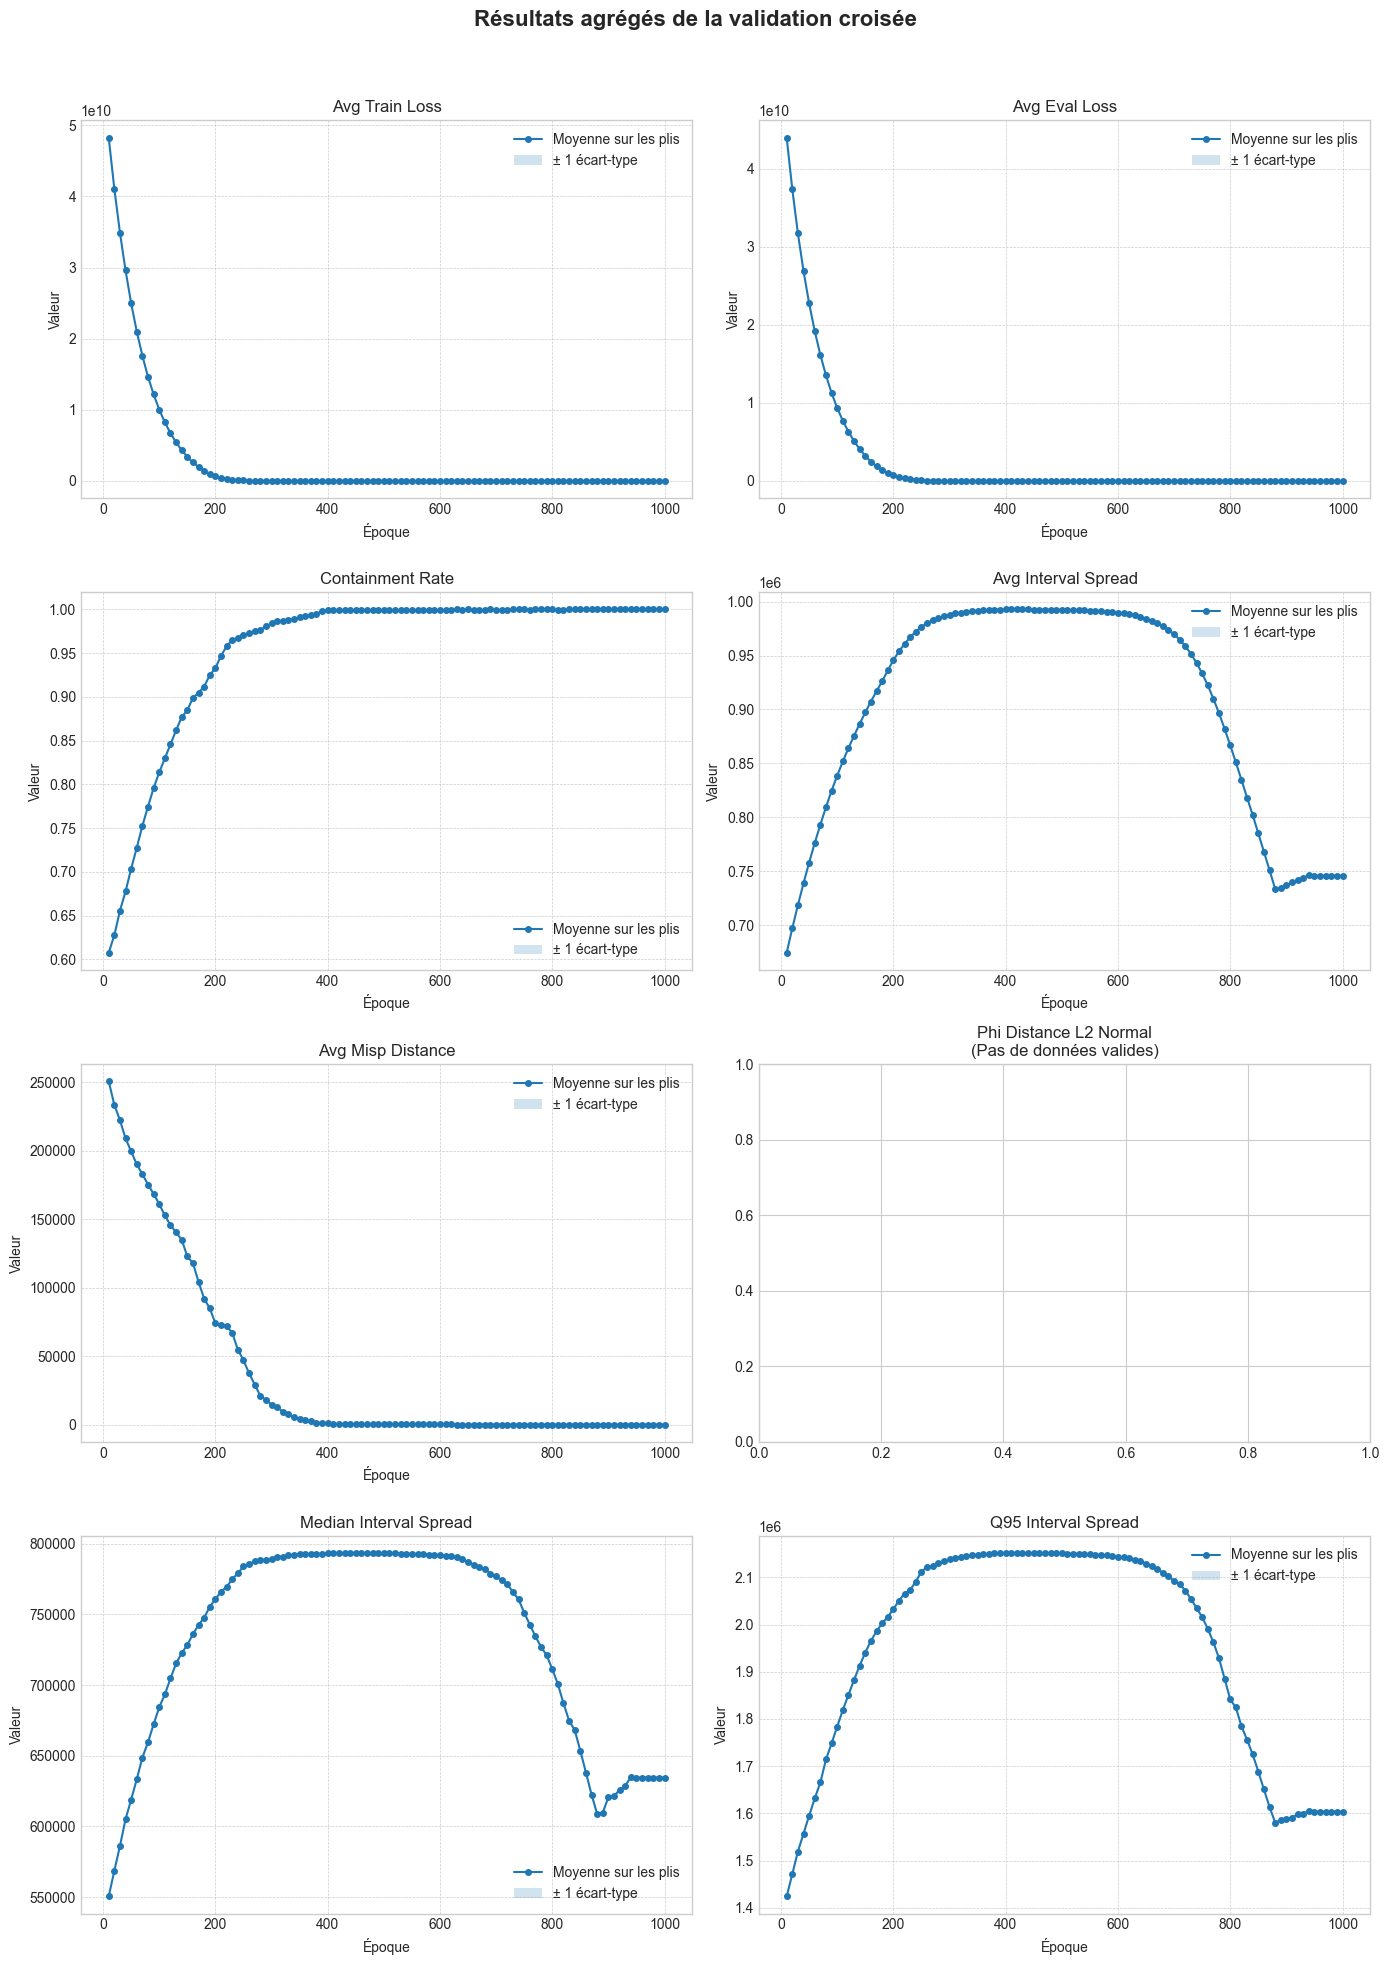

In [ ]:
plot_metrics_complet([model_simple.history,model_simple.history])